In [1]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

import tensorflow as tf
import numpy as np
from sklearn.utils import class_weight
from sklearn.metrics import classification_report

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [4]:
data_dir_train = Path("../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = Path("../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [5]:
# went with batch size of 32 bc it's a good balance between speed and memory usage.
batch_size = 32
img_height = 180
img_width = 180
validation_split = 0.2

random.seed(123)
tf.random.set_seed(123)
np.random.seed(123)

In [6]:
if not data_dir_train.exists():
    raise FileNotFoundError(f"Training directory not found: {data_dir_train}")
if not data_dir_test.exists():
    raise FileNotFoundError(f"Testing directory not found: {data_dir_test}")


# preparing the training set.
# added validation split for cross-validation.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=validation_split,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int'  
)

# same as above but for the val subset of the training data.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=validation_split,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int'
)

# didnt split test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int'
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.
Found 118 files belonging to 9 classes.


In [7]:
class_names = train_ds.class_names
expected_classes = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 
                    'melanoma', 'nevus', 'pigmented benign keratosis', 
                    'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
if class_names != expected_classes:
    raise ValueError(f"Unexpected class names. Expected {expected_classes}, but got {class_names}")
print("Class Names:", class_names)

Class Names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


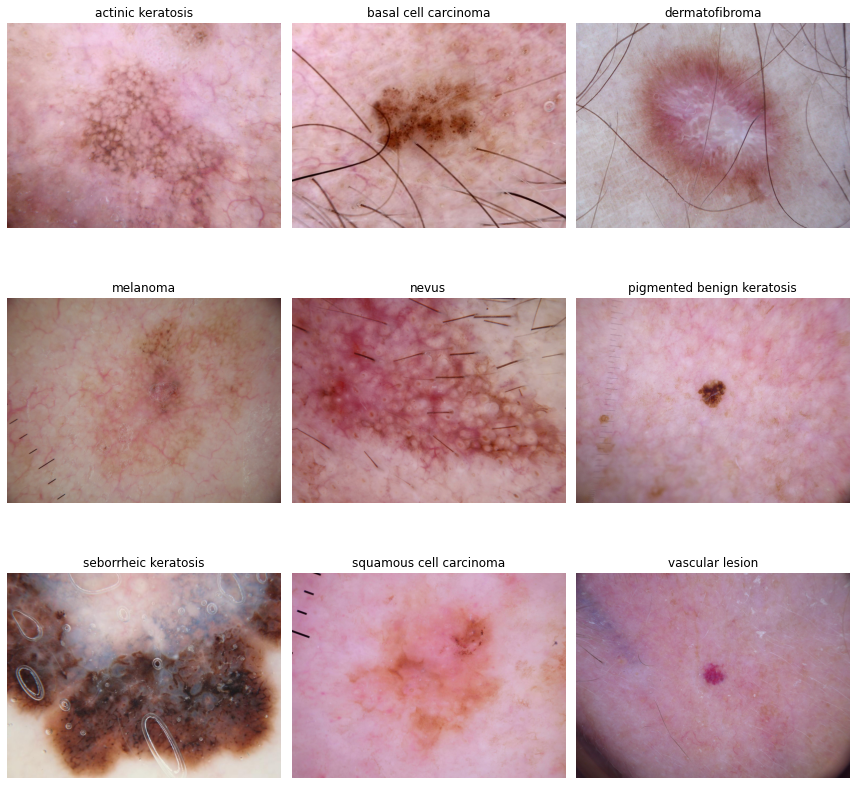

In [8]:

# just wanna make sure my classes are as expected.

num_classes = len(class_names) 

cols = 3
rows = num_classes // cols + int(num_classes % cols > 0)
plt.figure(figsize=(cols * 4, rows * 4))
for i in range(num_classes):
    plt.subplot(rows, cols, i + 1)
    
    class_dir = data_dir_train / class_names[i]
    image_files = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.jpeg')) + list(class_dir.glob('*.png'))
    if not image_files:
        raise FileNotFoundError(f"No images found in {class_dir}")
    image_path = random.choice(image_files)  
    image = mpimg.imread(str(image_path))
    
    plt.title(class_names[i])
    plt.imshow(image)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:

for image_batch, labels_batch in train_ds.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Labels batch shape:", labels_batch.shape)

Image batch shape: (32, 180, 180, 3)
Labels batch shape: (32,)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE  # letting tf figure out the best settings
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) # shuffle training data for better learning
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) # validation doesn't need shuffling
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [2]:
#added some data augemtation to avoid overfitting

data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

# for the model i stacked Conv2D and MaxPooling layers to extract spatial features from images.

model = Sequential([
    Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)),  # resxale layer to normalize pixel values
    data_augmentation,

    # first convolutional block: 32 filters, relu activation.

    Conv2D(32, (3, 3), padding="same", activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),

    # second block: more filters for deeper feature extraction.
    Conv2D(64, (3, 3), padding="same", activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    
    Conv2D(128, (3, 3), padding="same", activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),

    Conv2D(256, 3, padding="same", activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),

    #pretty deep neural network but performing better than without
    Conv2D(512, 3, padding="same", activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    
    Flatten(),
    Dense(1024, activation="relu"),
    Dropout(0.5),
    Dense(units=num_classes, activation='softmax')
])

In [21]:
opt = Adam(learning_rate=0.001) # went with adam bc its fast and works well for most problems.

model.compile(
    optimizer=opt,
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 90, 90, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 64)       

In [22]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # stop if no improvement
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

# computing class weights to handle class imbalance.
labels = np.concatenate([y.numpy() for x, y in train_ds], axis=0)
class_weights_values = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = {i: weight for i, weight in enumerate(class_weights_values)}
print("Class Weights:", class_weights)

Class Weights: {0: 2.1642512077294684, 1: 0.6443725278676735, 2: 2.585858585858586, 3: 0.5656565656565656, 4: 0.7188126754913758, 5: 0.5381381381381382, 6: 3.4329501915708813, 7: 1.402190923317684, 8: 1.731400966183575}


In [23]:
epochs = 25 # training for up to 25 epochs but stops earlier if val_loss doesn't improve
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop, checkpoint, reduce_lr],
    class_weight=class_weights
)


Epoch 1/25
56/56 [==============================] - 5s 58ms/step - loss: 9.3915 - accuracy: 0.2533 - val_loss: 14.6206 - val_accuracy: 0.1521
Epoch 2/25
56/56 [==============================] - 3s 53ms/step - loss: 4.0775 - accuracy: 0.2768 - val_loss: 15.5103 - val_accuracy: 0.0962
Epoch 3/25
56/56 [==============================] - 3s 53ms/step - loss: 2.0050 - accuracy: 0.2600 - val_loss: 20.8702 - val_accuracy: 0.1834
Epoch 4/25
56/56 [==============================] - 3s 54ms/step - loss: 1.7449 - accuracy: 0.3097 - val_loss: 11.4627 - val_accuracy: 0.1454
Epoch 5/25
56/56 [==============================] - 3s 55ms/step - loss: 1.6806 - accuracy: 0.3186 - val_loss: 10.5758 - val_accuracy: 0.1544
Epoch 6/25
56/56 [==============================] - 3s 55ms/step - loss: 1.6510 - accuracy: 0.3382 - val_loss: 4.9849 - val_accuracy: 0.1611
Epoch 7/25
56/56 [==============================] - 3s 56ms/step - loss: 1.6684 - accuracy: 0.3198 - val_loss: 3.2993 - val_accuracy: 0.2640
Epoch 8/

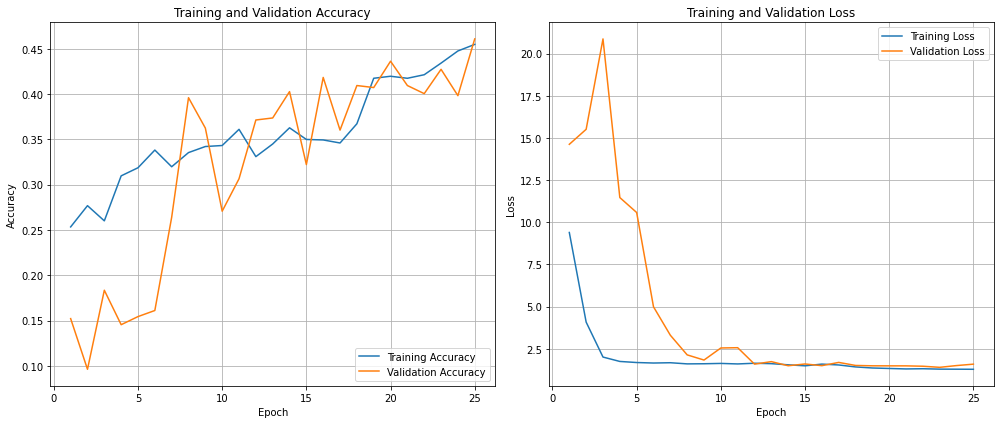

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 6))

# plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# plotting loss.
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

In [25]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

4/4 [==============================] - 0s 82ms/step - loss: 4.1025 - accuracy: 0.3898
Test Accuracy: 0.3898
Test Loss: 4.1025


In [26]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
                            precision    recall  f1-score   support

         actinic keratosis       0.50      0.44      0.47        16
      basal cell carcinoma       0.43      0.38      0.40        16
            dermatofibroma       0.31      0.25      0.28        16
                  melanoma       0.30      0.19      0.23        16
                     nevus       0.48      0.88      0.62        16
pigmented benign keratosis       0.31      0.25      0.28        16
      seborrheic keratosis       0.09      0.33      0.14         3
   squamous cell carcinoma       0.40      0.25      0.31        16
           vascular lesion       0.75      1.00      0.86         3

                  accuracy                           0.39       118
                 macro avg       0.40      0.44      0.40       118
              weighted avg       0.39      0.39      0.38       118



In [ ]:
# model not great thus far, more work to to in future w more data augmentation and better handling of imbalance